In [2]:
import pandas
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
from torch.autograd import Variable
import torch.optim as optim
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import seaborn as sn
from sklearn.metrics import confusion_matrix
import gensim.models
import gensim.corpora
import gensim as gs
import gensim.models.coherencemodel
from gensim.models import FastText
from sklearn.metrics import classification_report
from joblib import dump, load

In [244]:
from gensim.models.phrases import Phrases, Phraser

In [280]:
class Lin_Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_hidden_layers):
        super(Lin_Net, self).__init__()
        self.act_function = nn.ReLU()
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = [nn.Linear(hidden_dim, hidden_dim) for i in range(0, num_hidden_layers)]
        self.lin4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.act_function(self.lin1(x))
        for hidden_layer in self.hidden_layers: 
            x = self.act_function(hidden_layer(x))
        x = self.lin4(x)
        return x
    
class MyDataset(D.Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = torch.from_numpy(x_tensor)
        self.y = torch.from_numpy(y_tensor)
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

In [324]:
def load_lex_data(dataset_name, feature_set_name, features, batch_size, split_factor=0.2):
    print("loading lex data", dataset_name, feature_set_name)
    inputs = []
    dataset = pd.read_csv("../cleaned/" + dataset_name + "_clean.csv")
    targets = dataset["a"]
    inputs = dataset[features]
    return make_loader(inputs, targets, split_factor)
    
def load_vector_data(dataset_name, bgr=False, split_factor=0.2):
    print("loading vector data for", dataset_name)
    sentences = pd.read_csv("../cleaned/" + dataset_name + "_stems.csv", delimiter=",").astype(str).values.tolist()
    targets = pd.read_csv("../cleaned/" + dataset_name + "_clean.csv")["a"]
    vector_model = FastText.load("../models/word_embeddings/" + dataset_name + "_fasttext")
    # replace placeholders (" "), make one-string-sentences
    print("... replacing placeholders")
    for index, sample in enumerate(sentences): 
            sentences[index] = list(filter((" ").__ne__, sample))
    inputs = [" ".join(sentence) for sentence in sentences]
    tokenized = sentences
    if bgr:
        bigram = Phraser.load("../models/bigrams/bigram_" + dataset_name + ".pkl")
        bigrammed = [bigram[sentence] for sentence in sentences]
        tokenized = bigrammed
    inputs = [np.sum(vector_model.wv[sent], 0).tolist() if sent else np.zeros(32) for sent in tokenized]   
    inputs = np.array(inputs)
    train_loader, val_loader, test_loader = make_loader(inputs, targets, split_factor)
    return len(inputs[0]), train_loader, val_loader, test_loader

def load_topic_data(dataset_name, split_factor=0.2):
    print("loading lex data", dataset_name, feature_set_name)
    inputs = []
    num_topics = num_topics_dict[dataset_name]
    dataset = pd.read_csv("../cleaned/" + dataset_name + "_clean.csv")
    targets = dataset["a"]
    dataset = dataset.astype(str).values.tolist() 
    dic = gs.corpora.Dictionary.load("../models/dictionary/" + dataset_name + "_dictionary")
    lda_model = gensim.models.ldamulticore.LdaMulticore.load("../models/topic_models/" + dataset_name + "_ldamodel")   
    print("../models/topic_models/" + dataset_name + "_ldamodel")
    for index, sample in enumerate(dataset): 
        dataset[index] = list(filter((" ").__ne__, sample))
    for i, sample in enumerate(dataset):
        sentence = dic.doc2bow(dataset[i])
        topics = lda_model.get_document_topics(sentence, minimum_probability=0.0)
        topic_vec = [topics[i][1] for i in range(num_topics)] 
        inputs.append(topic_vec)
    train_loader, val_loader, test_loader = make_loader(inputs, targets, split_factor)
    topics_num = len(lda_model.get_topics())
    return topics_num, train_loader, val_loader, test_loader
    

def make_loader(inputs, targets, test_size):
    # make train and test sets
    train_x, val_x, train_y, val_y = train_test_split(inputs, targets, test_size=split_factor)
    train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=split_factor)
    train_data = MyDataset(np.asarray(train_x), np.asarray(train_y))
    val_data = MyDataset(np.asarray(val_x), np.asarray(val_y))
    test_data = MyDataset(np.asarray(test_x), np.asarray(test_y))
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size)
    val_loader = DataLoader(dataset=val_data, batch_size=round(batch_size*split_factor))
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    return train_loader, val_loader, test_loader



In [241]:
def convert_to_cuda(cuda, inputs, targets, net):
    if cuda: 
        return inputs.cuda(), targets.cuda(), net.cuda()
    else: 
        return inputs, targets, net
    
def log(file_name, message, net=False, epoch=False):
    print(message)
    log = open("{}{}_{}".format("../logs/", file_name, ".txt"), "a")
    log.write(message)
    log.close()
    # save net
    if net and epoch: 
        torch.save(net.state_dict(), "{}{}_{}{}".format("../nets/", file_name, epoch, ".pt"))

def plot_intersection(file_name, plot_type, y1, y2, desc=True, intersection=False):
    x, y1, y2  = list(range(1, len(y1)+1)), np.asarray(y1), np.asarray(y2)
    epochs = len(x)
    fig = plt.figure()
    plt.clf()
    if plot_type == "f1_score":
        max_y, max_x = round(max(y2),2), y2.tolist().index(max(y2))+1
        desc = "\ndataset: {}\nbest validation_f1_score = {}, in epoch {}\n blue=train_f1, green=val_f1".format(
                file_name, max_y, max_x)
        plt.plot(x, y1, "b-", x, y2, "g-", max_x, max_y, "ro")
        plt.ylim(0,1.1)
    elif plot_type == "loss":
        desc = "\ndataset: {}\n blue=train_f1, green=val_f1".format(file_name)
        plt.plot(x, y1, "b-", x, y2, "g-")
        plt.ylim(0,max([round(max(y1),2), round(max(y2),2)]))
    plt.ylabel(plot_type)
    plt.xlabel("epochs")
    plt.grid()
    plt.xlim(0, epochs)
    fig.text(0.5, -0.15, desc.replace("../logs/", ""), ha='center')
    fig.savefig("{}{}_{}{}".format("../img/", file_name, plot_type, "_intersection.png"), bbox_inches="tight")
    
def draw_confusion_matrix(file_name, test_y, pred_y, f1_score): 
    fig = plt.figure()
    hm = sn.heatmap(confusion_matrix(test_y, pred_y), fmt="d", linewidth=0.5, annot=True, square=True, xticklabels=["h", "s", "a", "f"], yticklabels=["h", "s", "a", "f"], cmap="PuRd")
    ax1 = fig.add_axes(hm)
    ax1.set(xlabel="predicted", ylabel="target")
    desc = "dataset: {}".format(file_name)
    #if feature_set_name == "topics": desc = "dataset: {} ({}), trained with {} topics\nscore: {}, f1_score: {}".format(dataset_name, feature_set_name, num_topics, round(score,2), round(f1_scoore,2))
    #else: desc = "dataset: {} ({}) \nscore: {}, f1_score: {}".format(dataset_name, feature_set_name, round(score,2), round(f1_scoore,2)) 
    desc = "dataset: {} ({}) \nf1_score: {}".format(dataset_name, feature_set_name, round(f1_score,2)) 
    fig.text(0.5, -0.1, desc, ha='center')
    plt.show()
    fig.savefig("{}{}_{}".format("../img/", file_name, "confusion.png"), bbox_inches="tight")

In [326]:
def train(train_loader, val_loader, net, epochs, cuda, lr, file_name, print_every):
    print("training")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    train_f1, val_f1, train_e, val_e = [], [], [], []
    # training cycle
    for epoch in range(epochs):
        # for every batch in the train_loader
        net.train()
        for index, (train_inputs, train_targets) in enumerate(train_loader):
            train_inputs, train_targets = train_inputs.float(), train_targets.long()
            train_inputs, train_targets, net = convert_to_cuda(cuda, train_inputs, train_targets, net)
            train_pred = net(train_inputs)
            train_loss = criterion(train_pred.float(), train_targets)
            optimizer.zero_grad(); train_loss.backward(); optimizer.step()# save error
            train_pred = [item.index(max(item)) for item in train_pred.tolist()]
            tf1, tloss = f1_score(train_targets.tolist(), train_pred, average="weighted"), train_loss.item()
        net.eval()
        for index, (val_inputs, val_targets) in enumerate(val_loader):
            val_inputs, val_targets = val_inputs.float(), val_targets.long()
            val_inputs, val_targets, net = convert_to_cuda(cuda, val_inputs, val_targets, net)
            val_pred = net(val_inputs)
            val_loss = criterion(val_pred.float(), val_targets)
            val_pred = [item.index(max(item)) for item in val_pred.tolist()]
            vf1, vloss = f1_score(val_targets.tolist(), val_pred, average="weighted"), val_loss.item()
        train_f1.append(f1_score(train_targets.tolist(), train_pred, average="weighted"))
        val_f1.append(f1_score(val_targets.tolist(), val_pred, average="weighted"))
        train_e.append(train_loss.item())
        val_e.append(val_loss.item())
        # write logs and files 
        if epoch % print_every == 0:
            log(file_name, "\nepoch: {}, \n...train_f1: {}, train_loss: {}, \tval_f1: {}, val_loss: {}".format(
                epoch, train_f1[-1:], train_e[-1:], val_f1[-1:], val_e[-1:]), net=net, epoch=epoch)
    plot_intersection(file_name, "f1_score", train_f1, val_f1)
    plot_intersection(file_name, "loss", train_e, val_e)

def test(test_loader, net, file_name): 
    print("testing")
    all_targets, preds, test_e = [], [], []
    net.eval()
    for index, (inputs, targets) in enumerate(test_loader):
        inputs, test_targets = inputs.float(), targets.long()
        inputs, test_targets, net = convert_to_cuda(cuda, inputs, targets, net)
        test_pred = net(inputs).tolist()[0]
        preds.append(test_pred.index(max(test_pred)))
        all_targets.append(test_targets.tolist()[0])
    test_f1 = f1_score(all_targets, preds, average="weighted")
    with open("../reports/report_"+file_name+".txt", 'w') as f:
        print(file_name + ", f1_score: " + str(test_f1) + ":\n\n" + 
          classification_report(all_targets, preds,target_names=classes), file=f)
    log(file_name, "\n...test_f1: {}".format(test_f1))
    draw_confusion_matrix(file_name, all_targets, preds, test_f1)

def run(dataset_name, feature_set_name):
    file_name = "net_lin_{}({})".format(dataset_name, feature_set_name)
    print("running ", file_name)
    open("{}{}_{}".format("../logs/", file_name, ".txt"), "w").close()
    if feature_set_name == "topics":
        num_topics, train_loader, val_loader, test_loader = load_topic_data(dataset_name)
        net = Lin_Net(num_topics, output_dim, hidden_dim, num_hidden_layers)
        train(train_loader, val_loader, net, epochs, cuda, lr, file_name, print_every)
        test(test_loader, net, file_name)
    elif feature_set_name == "vec-unigram":
        input_dim, train_loader, val_loader, test_loader = load_vector_data(dataset_name)
        net = Lin_Net(input_dim, output_dim, hidden_dim, num_hidden_layers)
        train(train_loader, val_loader, net, epochs, cuda, lr, file_name, print_every)
        test(test_loader, net, file_name)
    elif feature_set_name == "vec-bigram":
        input_dim, train_loader, val_loader, test_loader = load_vector_data(dataset_name, True)
        net = Lin_Net(input_dim, output_dim, hidden_dim, num_hidden_layers)
        train(train_loader, val_loader, net, epochs, cuda, lr, file_name, print_every)
        test(test_loader, net, file_name)
    else: 
        train_loader, val_loader, test_loader = load_lex_data(dataset_name, feature_set_name, feature_sets[dataset_name + "_" + feature_set_name], batch_size, split_factor)
        net = Lin_Net(len(feature_sets[dataset_name + "_" + feature_set_name]), output_dim, hidden_dim, num_hidden_layers)
        train(train_loader, val_loader, net, epochs, cuda, lr, file_name, print_every)
        test(test_loader, net, file_name)
        
    

In [330]:
# create variables 
print("creating variables")
feature_set_names = ["full", "half", "vec-unigram", "vec-bigram", "topic"]
feature_sets = {
    "norm_test_full": ["wc", "ewc", "cpc", "hc", "sc", "ac", "fc"],
    "norm_test_lex": ["hc", "sc", "ac", "fc"],
    "norm_emotion_full": ["wc", "ewc", "hc", "sc", "ac", "fc"],
    "norm_emotion_lex": ["hc", "sc", "ac", "fc"],
    "norm_tweet_full": ["wc", "ewc", "cpc", "hc", "sc", "ac", "fc"],
    "norm_tweet_lex": ["hc", "sc", "ac", "fc"]
}
num_topics_dict = {
    "norm_emotion": 186,
    "norm_tweet": 79,
    "norm_test": 79
}
classes = ["happiness", "sadness", "anger", "fear"]

types = {
    "text": object, 
    "a": int, 
    "wc": float,
    "uwc": float,
    "ewc": float,
    "cpc": float,
    "hc": float,
    "sc": float,
    "ac": float,
    "c": float
}

criterion = nn.CrossEntropyLoss()
cuda = torch.cuda.is_available()
batch_size = 16
epochs = 5000 + 1
print_every = 125
split_factor = 0.2
output_dim = 4
hidden_dim = 256
num_hidden_layers = 2
lr = 0.01

creating variables


running  net_lin_norm_test(full)
loading lex data norm_test full
make_loader, inputs_shape (5903, 7)
make_loader, targets_shape (5903,)
make_loader, train_x_shape (3777, 7)
256
make_loader, train_data_len 3777
net 7
training


/home/marcel/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



epoch: 0, 
...train_f1: [0.1949359663701242], train_loss: [1.3142006397247314], 	val_f1: [0.09375], val_loss: [1.342943787574768]

epoch: 5, 
...train_f1: [0.4429522103711528], train_loss: [1.208661675453186], 	val_f1: [0.28125], val_loss: [1.2325236797332764]

epoch: 10, 
...train_f1: [0.4523033297480459], train_loss: [1.182618498802185], 	val_f1: [0.4375], val_loss: [1.2573891878128052]
testing

...test_f1: 0.44103940152494664


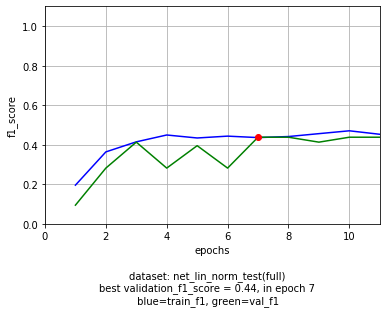

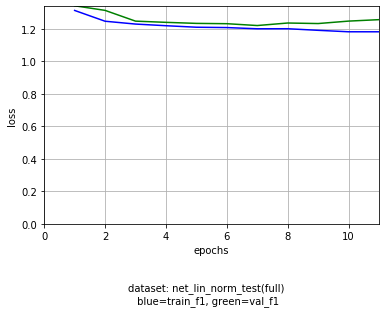

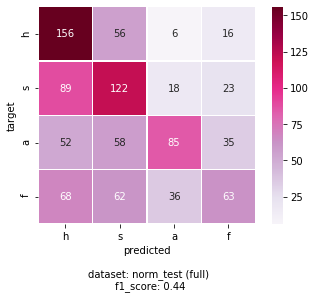

running  net_lin_norm_test(vec-unigram)
loading vector data for norm_test
... replacing placeholders
make_loader, inputs_shape (5903, 32)
make_loader, targets_shape (5903,)
make_loader, train_x_shape (3777, 32)
256
make_loader, train_data_len 3777
net 32
training


/home/marcel/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



epoch: 0, 
...train_f1: [0.13124842110690077], train_loss: [1.3956753015518188], 	val_f1: [0.1], val_loss: [1.3894047737121582]

epoch: 5, 
...train_f1: [0.24603166952361227], train_loss: [1.3581759929656982], 	val_f1: [0.1125], val_loss: [1.3785117864608765]

epoch: 10, 
...train_f1: [0.2784921441142179], train_loss: [1.3552418947219849], 	val_f1: [0.2416666666666667], val_loss: [1.3673385381698608]
testing

...test_f1: 0.2599396152502616


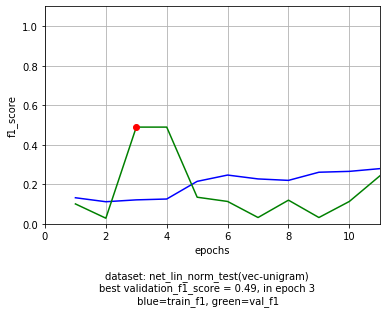

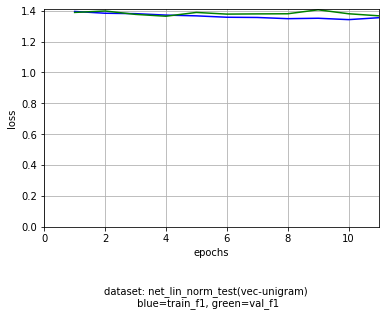

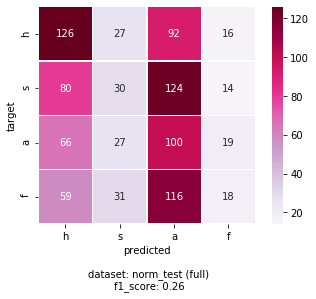

running  net_lin_norm_test(vec-bigram)
loading vector data for norm_test
... replacing placeholders
make_loader, inputs_shape (5903, 32)
make_loader, targets_shape (5903,)
make_loader, train_x_shape (3777, 32)
256
make_loader, train_data_len 3777
net 32
training


/home/marcel/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



epoch: 0, 
...train_f1: [0.08109934669970714], train_loss: [1.4034860134124756], 	val_f1: [0.3333333333333333], val_loss: [1.3493939638137817]


/home/marcel/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



epoch: 5, 
...train_f1: [0.23162890614326562], train_loss: [1.3719826936721802], 	val_f1: [0.33333333333333326], val_loss: [1.2719135284423828]

epoch: 10, 
...train_f1: [0.33779541365159965], train_loss: [1.3531159162521362], 	val_f1: [0.42857142857142855], val_loss: [1.2406713962554932]
testing

...test_f1: 0.26351754600568666


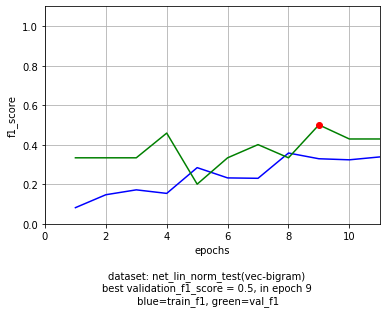

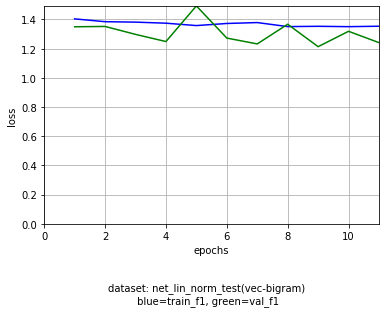

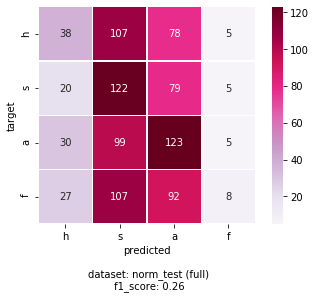

running  net_lin_norm_test(topics)
loading lex data norm_test full
dataset_name norm_test
num_topics 79
../models/topic_models/norm_test_ldamodel
make_loader, inputs_shape (5903, 79)
make_loader, targets_shape (5903,)
make_loader, train_x_shape (3777, 79)
256
make_loader, train_data_len 3777
net 79
training


/home/marcel/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



epoch: 0, 
...train_f1: [0.8842030510630495], train_loss: [0.42919066548347473], 	val_f1: [0.6375000000000001], val_loss: [0.8724961280822754]

epoch: 5, 
...train_f1: [0.9149540898404199], train_loss: [0.25964099168777466], 	val_f1: [0.6625000000000001], val_loss: [0.7309582829475403]

epoch: 10, 
...train_f1: [0.9149540898404199], train_loss: [0.26059314608573914], 	val_f1: [0.6625000000000001], val_loss: [0.7123679518699646]
testing

...test_f1: 0.9130597961077829


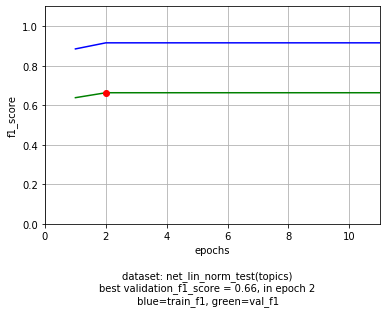

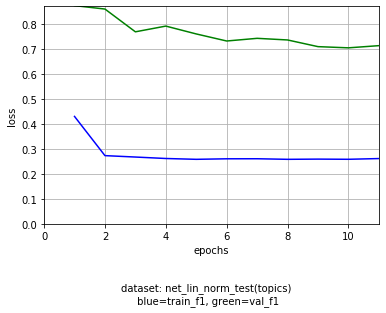

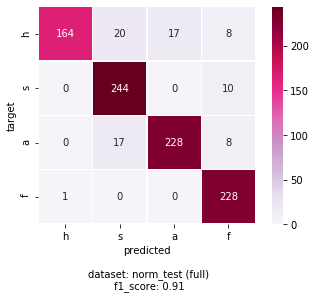

In [328]:
datasets = ["norm_tweet", "norm_emotion"]
feature_set_names = ["full", "half", "topic"]
datasets = ["norm_test"]
feature_set_names = ["full"]

for ["norm_tweet", "norm_emotion"] in ["full", "lex", "vec-unigram", "vec-bigram", "topics"]: 
    for feature_set_name in feature_set_names: 
        run(dataset_name, feature_set_name)